In [17]:
pip install --no-deps ../input/wtfml/

Processing /kaggle/input/wtfml
  Created wheel for wtfml: filename=wtfml-0.0.1-py3-none-any.whl size=8083 sha256=4638b365d2e2a18bcbbc32dc43072520e1af2079a22af2afb79519694791c6a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-9inqblw2/wheels/dc/c4/85/05298a5f34cb05f7d11c77e5c931f9c5adbf06666d85244726
Successfully built wtfml
  Attempting uninstall: wtfml
    Found existing installation: wtfml 0.0.1
    Uninstalling wtfml-0.0.1:
      Successfully uninstalled wtfml-0.0.1
Note: you may need to restart the kernel to use updated packages.


IMPORTING REQUIRED TOOLS:

In [18]:
import os
import ast

import pandas as pd
import numpy as np

import albumentations
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from wtfml.engine import RCNNEngine
from wtfml.data_loaders.image import RCNNLoader

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from PIL import ImageFile
import matplotlib.patches as patches

SETTING UP:

In [19]:
def format_prediction_string(boxes, scores):
    # function taken from: https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)


def collate_fn(batch):
    return tuple(zip(*batch))


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            pretrained=False, 
            pretrained_backbone=False
        )
        in_features = self.base_model.roi_heads.box_predictor.cls_score.in_features
        self.base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    def forward(self, images, targets):
        if targets is None:
            return self.base_model(images, targets)
        else:
            output = self.base_model(images, targets)
            if isinstance(output, list):
                return output
            loss = sum(loss for loss in output.values())
            return loss

In [20]:
class args:
	data_path = "../input/global-wheat-detection"
	epochs = 30
	device = "cuda"

In [33]:
model = Model()
model.to(args.device)

model.load_state_dict(
    torch.load('../input/wtfwheat/model.bin')
)

mean = (0., 0., 0.)
std = (1, 1, 1)
aug = albumentations.Compose(
    [albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)]
)

test_df = pd.read_csv(os.path.join(args.data_path, "sample_submission.csv"))
test_df.loc[:, "bbox"] = ["[0, 0, 10, 10]"] * len(test_df)
test_df.bbox = test_df.bbox.apply(ast.literal_eval)
test_df = test_df.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')
test_image_ids = test_df.image_id.values

images = test_df.image_id.values.tolist()
images = [os.path.join(args.data_path, "test", i + ".jpg") for i in images]
targets = test_df.bboxes.values

test_dataset = RCNNLoader(
    image_paths=images, 
    bounding_boxes=targets, 
    augmentations=aug
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn
)

prediction_strings = []
predictions = RCNNEngine.predict(test_loader, model, device=args.device)
for p in predictions:
    boxes = p['boxes'].numpy()
    scores = p['scores'].numpy()

    boxes = boxes[scores >= 0.5].astype(np.int32)
    scores = scores[scores >= 0.5]

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    prediction_strings.append(format_prediction_string(boxes, scores))

sample = pd.read_csv(os.path.join(args.data_path, "sample_submission.csv"))
sample.loc[:, "PredictionString"] = prediction_strings
sample.loc[:, "image_id"] = test_image_ids
sample.to_csv("submission.csv", index=False)

100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


IDENTIFYING WHEAT HEADS USING IMAGE ANALYSIS:

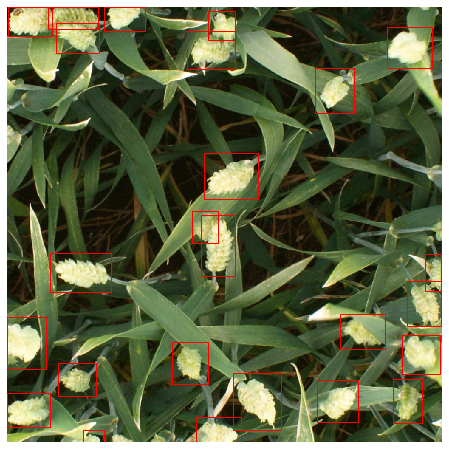

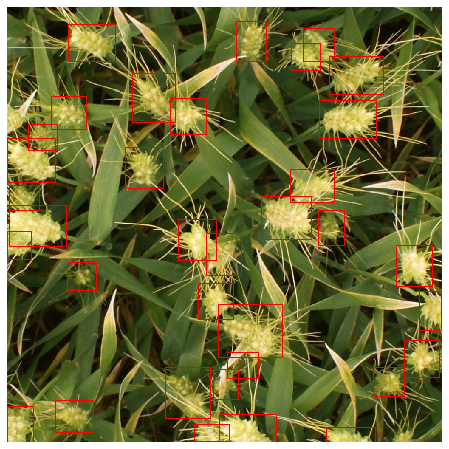

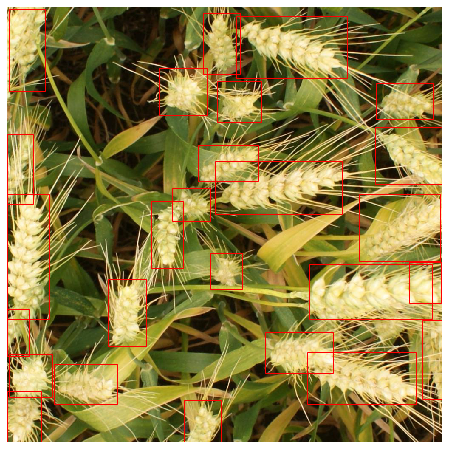

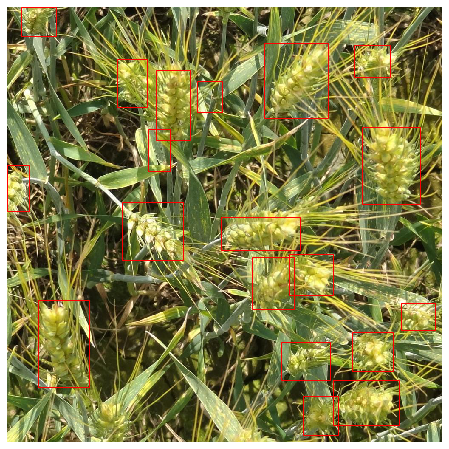

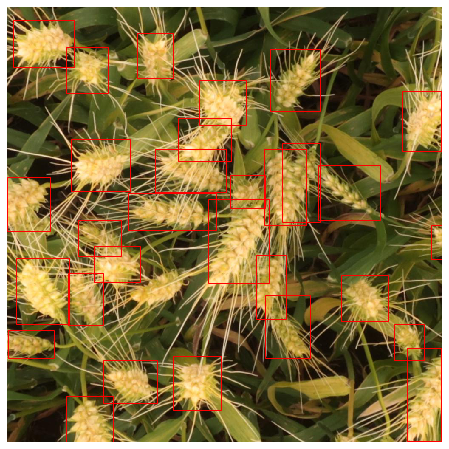

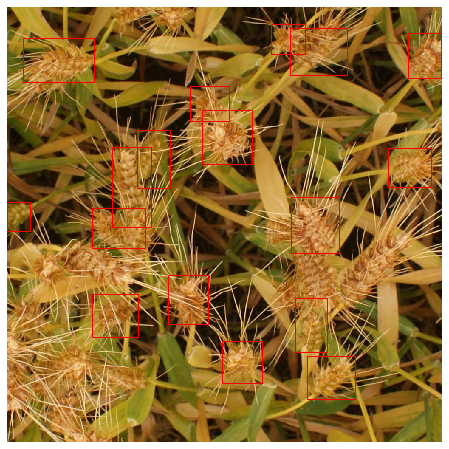

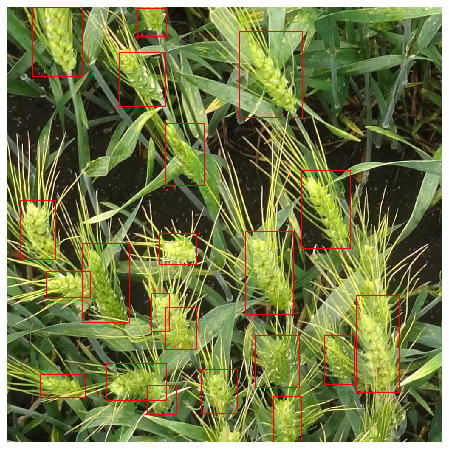

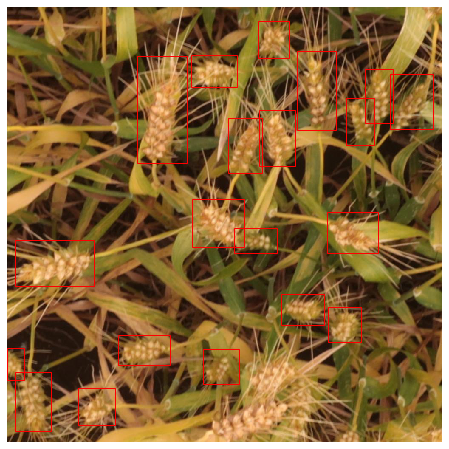

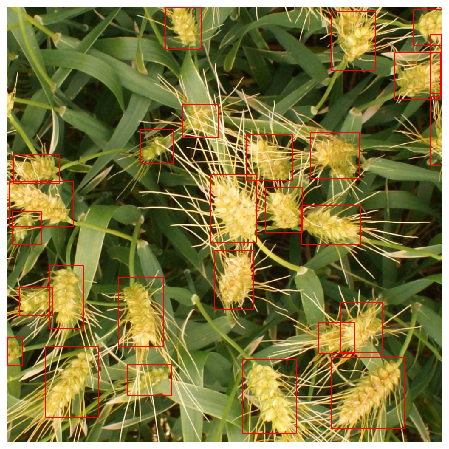

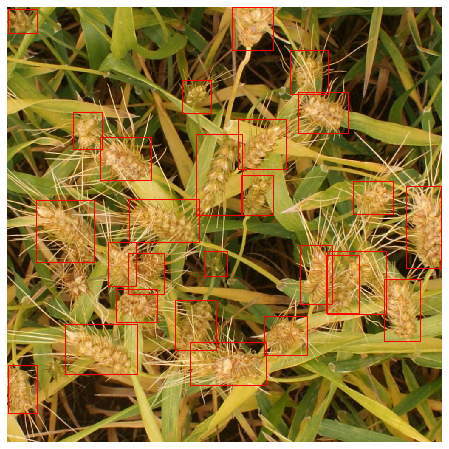

In [41]:
for idx in range(len(sample)):
    npimage = np.array(Image.open(os.path.join(args.data_path, "test", sample.image_id.values[idx] + ".jpg")))
    boxes = sample.PredictionString.values[idx]
    boxes = [x for i, x in enumerate(boxes.split()) if i % 5 != 0]
    boxes = np.array(boxes).reshape(-1, 4).astype(float)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for b in boxes:
        ax.add_patch(
         patches.Rectangle(
            (b[0], b[1]),
            b[2],
            b[3],
            fill=False,
            color='red')
        )
    ax.set_axis_off()
    ax.imshow(npimage)

In [34]:
sample

image_id                                   PredictionString
0  2fd875eaa  0.9999 532 861 112 134 0.9999 464 343 127 108 ...
1  348a992bb  0.9998 372 847 104 121 0.9998 733 218 136 91 0...
2  51b3e36ab  0.9998 538 22 261 145 0.9998 489 363 298 123 0...
3  51f1be19e  0.9998 605 84 151 177 0.9996 577 589 98 121 0....
4  53f253011  0.9998 786 630 109 108 0.9997 226 831 126 101 ...
5  796707dd7  0.9990 895 332 102 91 0.9990 377 630 96 117 0....
6  aac893a91  0.9999 59 0 117 161 0.9997 584 773 103 121 0.9...
7  cb8d261a3  0.9997 434 452 122 112 0.9997 18 858 84 140 0....
8  cc3532ff6  0.9998 762 823 173 169 0.9997 692 466 139 92 0...
9  f5a1f0358  0.9998 135 745 169 120 0.9996 68 454 137 145 0...

In [32]:
sample.shape

(10, 2)

In [40]:
sample.describe()

image_id                                   PredictionString
count          10                                                 10
unique         10                                                 10
top     53f253011  0.9998 605 84 151 177 0.9996 577 589 98 121 0....
freq            1                                                  1

In [ ]:
Conclusion:
    Accurate estimation of density and size of wheat head in different variety will 
    improved detection of wheat which would reduce wastage of several resources and 
    promote sustainability of land use and other factors of production.